In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pyupbit

In [10]:
coins = ['KRW-BTC', 'KRW-ETH', 'KRW-DOGE', 'KRW-BIGTIME', 'KRW-SUI', 'KRW-UXLINK', 'KRW-SOL', 'KRW-XRP', 'KRW-SXP']

In [3]:
coins = ['KRW-SUI', 'KRW-UXLINK', 'KRW-SOL', 'KRW-XRP', 'KRW-SXP']

In [3]:
len(coins)

9

In [4]:
interval = 'minute1'
count = 60 * 24 * 365 * 2

In [5]:
timestep = 1
window_size = 5
col_list = ['open', 'high', 'low', 'volatility', 'avg_change_rate', 'percentage_change', 'close_change', 'close']
n_features = len(col_list)

In [6]:
def inverse_transform_predictions(preds, scaler, label_idx=-1):
    dummy = np.zeros((len(preds), scaler.n_features_in_))
    dummy[:, label_idx] = preds[:, 0]
    return scaler.inverse_transform(dummy)[:, label_idx]

In [7]:
def get_percentage(future, past):
    return (future - past) / past * 100

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
for ticker in coins:
    df = pd.read_csv(f'../../data/from_pyupbit/{ticker}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['close_change'] = df['close'].diff().fillna(0)
    
    df.set_index('timestamp', inplace=True)
    
    df['percentage_change'] = get_percentage(df['close'], df['close'].shift(1)).fillna(0)
    df['volatility'] = df['percentage_change'].rolling(window=5).std()
    df['avg_change_rate'] = df['percentage_change'].rolling(window=5).mean()
    
    df = df[col_list].fillna(0)
    
    print(f'{ticker} data loaded')
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, f'models/fewer/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep):
        X.append(scaled_data[i:(i + timestep), :])
        y.append(scaled_data[i + timestep, -1])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(df) * .8)
    X_train, X_val = X[:train_size], X[train_size:] # n_samples, timestep, n_features
    y_train, y_val = y[:train_size], y[train_size:]
    
    train_dates = df.index[:train_size]
    val_dates = df.index[train_size:]
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    model.save(f'models/fewer/lstm_{ticker}.h5')
    
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    
    train_predict_original = inverse_transform_predictions(train_predict, scaler)
    val_predict_original = inverse_transform_predictions(val_predict, scaler)
    y_train_original = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
    y_val_original = inverse_transform_predictions(y_val.reshape(-1, 1), scaler)
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    val_score = np.sqrt(mean_squared_error(y_val, val_predict))
    print(f'{ticker} Train RMSE: {train_score:.6f} Validation RMSE: {val_score:.6f}')
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(train_dates, y_train_original, label='Actual', color = 'Blue')
    plt.plot(train_dates, train_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Train Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.savefig(f'results/fewer/{ticker}_train.png')
    
    plt.subplot(1, 1, 1)
    plt.plot(val_dates[:-1], y_val_original, label='Actual', color = 'Blue')
    plt.plot(val_dates[:-1], val_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Validation Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig(f'results/fewer/{ticker}_val.png')
    
    last_1_day = scaled_data[-timestep:]
    X_test = last_1_day[-1, :].reshape(1, timestep, n_features)
    pred = model.predict(X_test)
    pred = inverse_transform_predictions(pred, scaler)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)[-1, -1]:.6f} Pred {pred[0]:.6f}')
    print('.')

KRW-BTC data loaded
KRW-BTC train start
6570/6570 [==============================] - 10s 1ms/step
KRW-BTC Train RMSE: 0.000366 Validation RMSE: 0.010473
1/1 [==============================] - 0s 18ms/step
KRW-BTC Actual 141961000.000000 Pred 139116921.319962
.
KRW-ETH data loaded
KRW-ETH train start
6570/6570 [==============================] - 11s 2ms/step
KRW-ETH Train RMSE: 0.000747 Validation RMSE: 0.001255
1/1 [==============================] - 0s 12ms/step
KRW-ETH Actual 5125000.000000 Pred 5128848.254085
.
KRW-DOGE data loaded
KRW-DOGE train start
6570/6570 [==============================] - 14s 2ms/step
KRW-DOGE Train RMSE: 0.000630 Validation RMSE: 0.075753
1/1 [==============================] - 0s 15ms/step
KRW-DOGE Actual 483.200000 Pred 445.526554
.
KRW-BIGTIME data loaded
KRW-BIGTIME train start
958/958 [==============================] - 1s 1ms/step
KRW-BIGTIME Train RMSE: 0.002185 Validation RMSE: 0.007450
1/1 [==============================] - 0s 13ms/step
KRW-BIGTIME Act

KRW-SUI data loaded
KRW-SUI train start
5041/5041 [==============================] - 7s 1ms/step
KRW-SUI Train RMSE: 0.000462 Validation RMSE: 0.066823
1/1 [==============================] - 0s 14ms/step
KRW-SUI Actual 6794.000000 Pred 5531.014355
.
KRW-UXLINK data loaded
KRW-UXLINK train start
989/989 [==============================] - 3s 3ms/step
KRW-UXLINK Train RMSE: 0.000876 Validation RMSE: 0.023113
1/1 [==============================] - 0s 13ms/step
KRW-UXLINK Actual 2581.000000 Pred 2320.002261
.
KRW-SOL data loaded
KRW-SOL train start
6570/6570 [==============================] - 16s 2ms/step
KRW-SOL Train RMSE: 0.000581 Validation RMSE: 0.001718
1/1 [==============================] - 0s 13ms/step
KRW-SOL Actual 290550.000000 Pred 290674.027444
.
KRW-XRP data loaded
KRW-XRP train start
6570/6570 [==============================] - 16s 2ms/step
KRW-XRP Train RMSE: 0.000257 Validation RMSE: 0.058847
1/1 [==============================] - 0s 13ms/step
KRW-XRP Actual 3372.000000 Pre

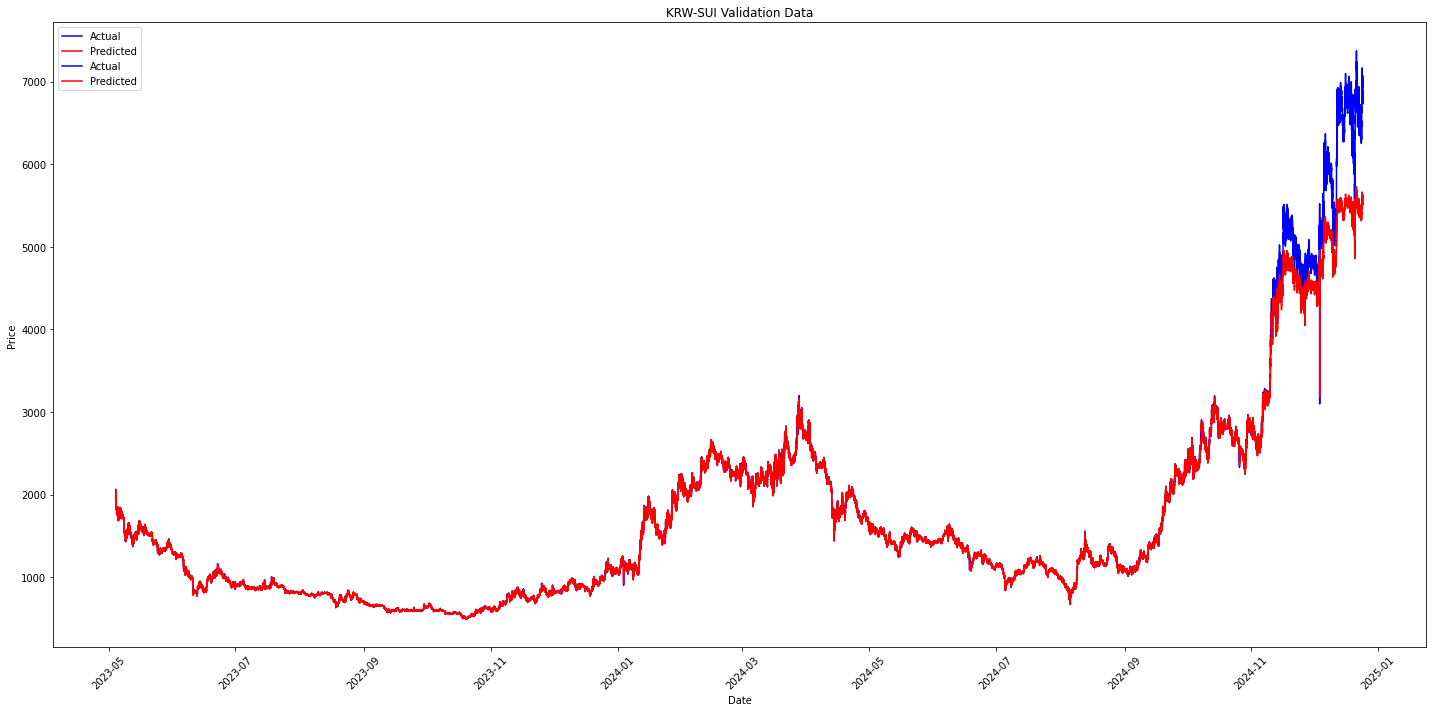

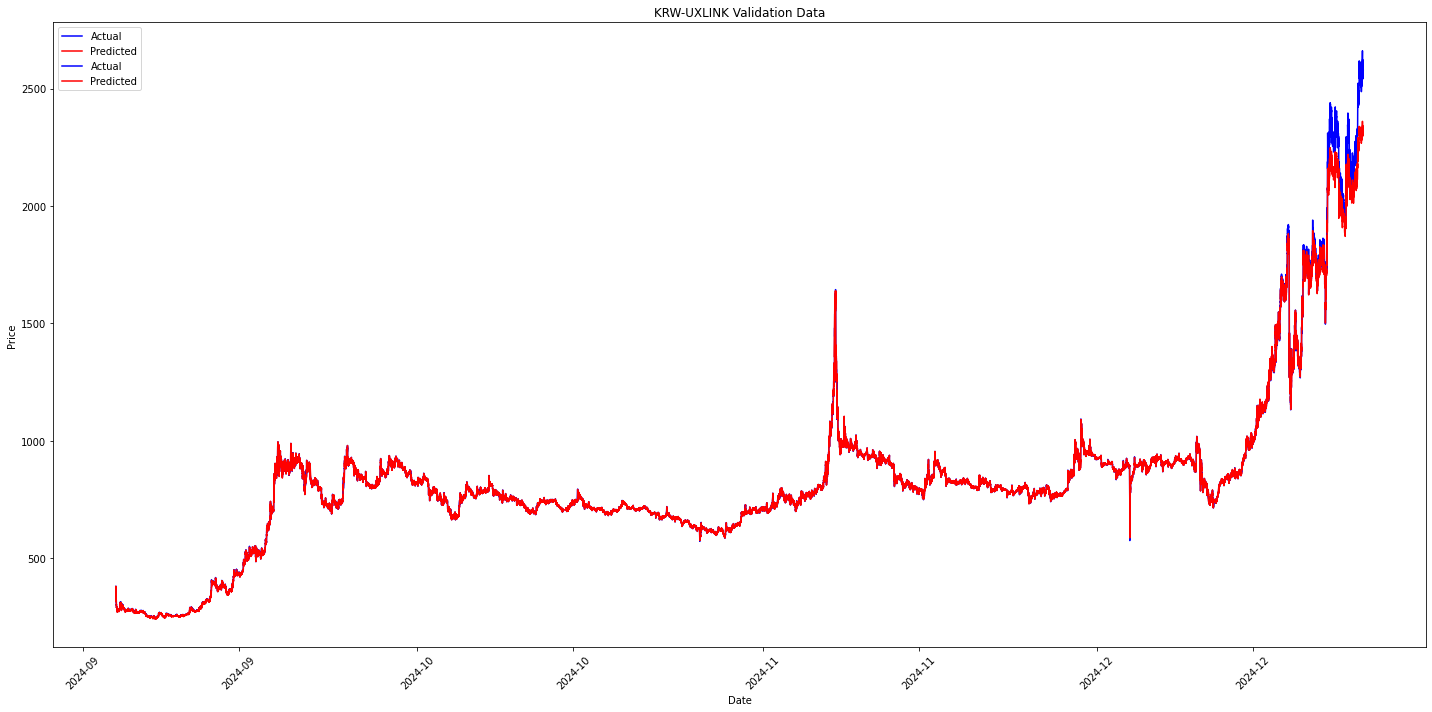

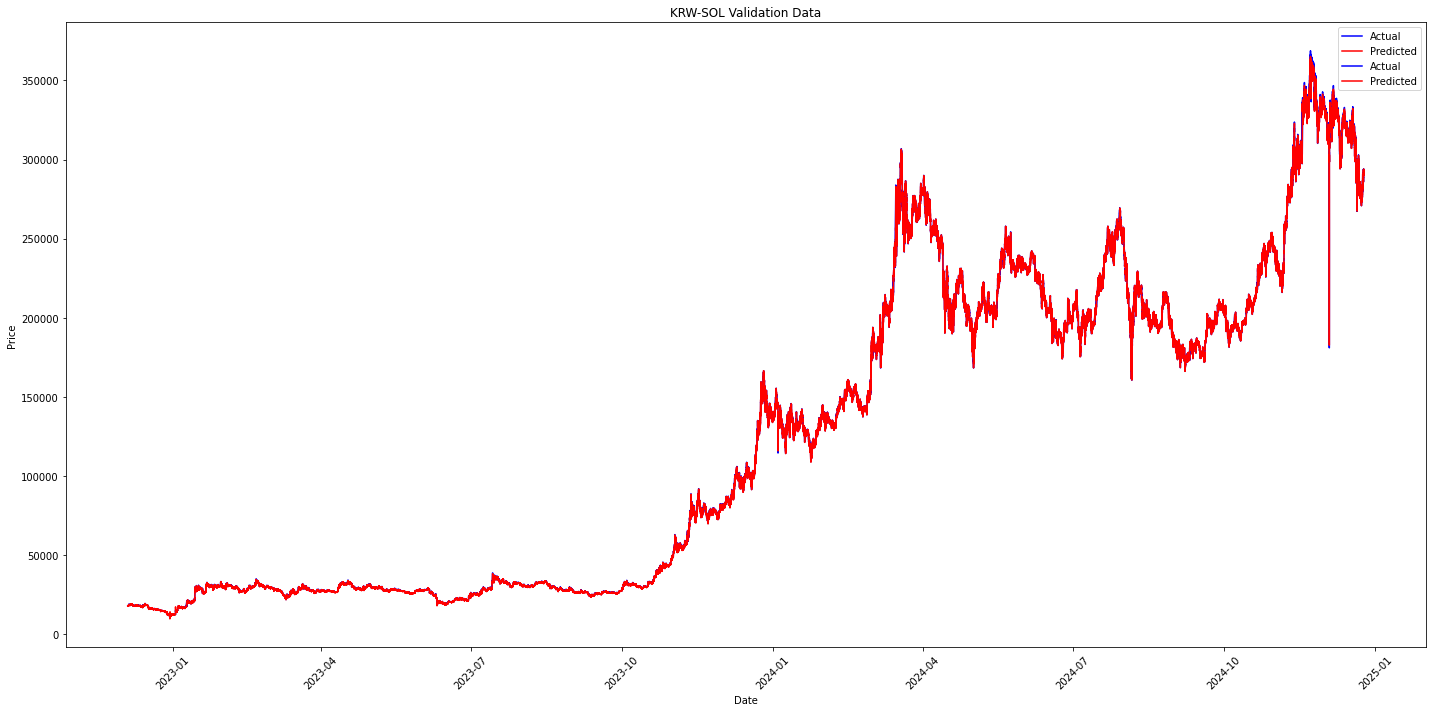

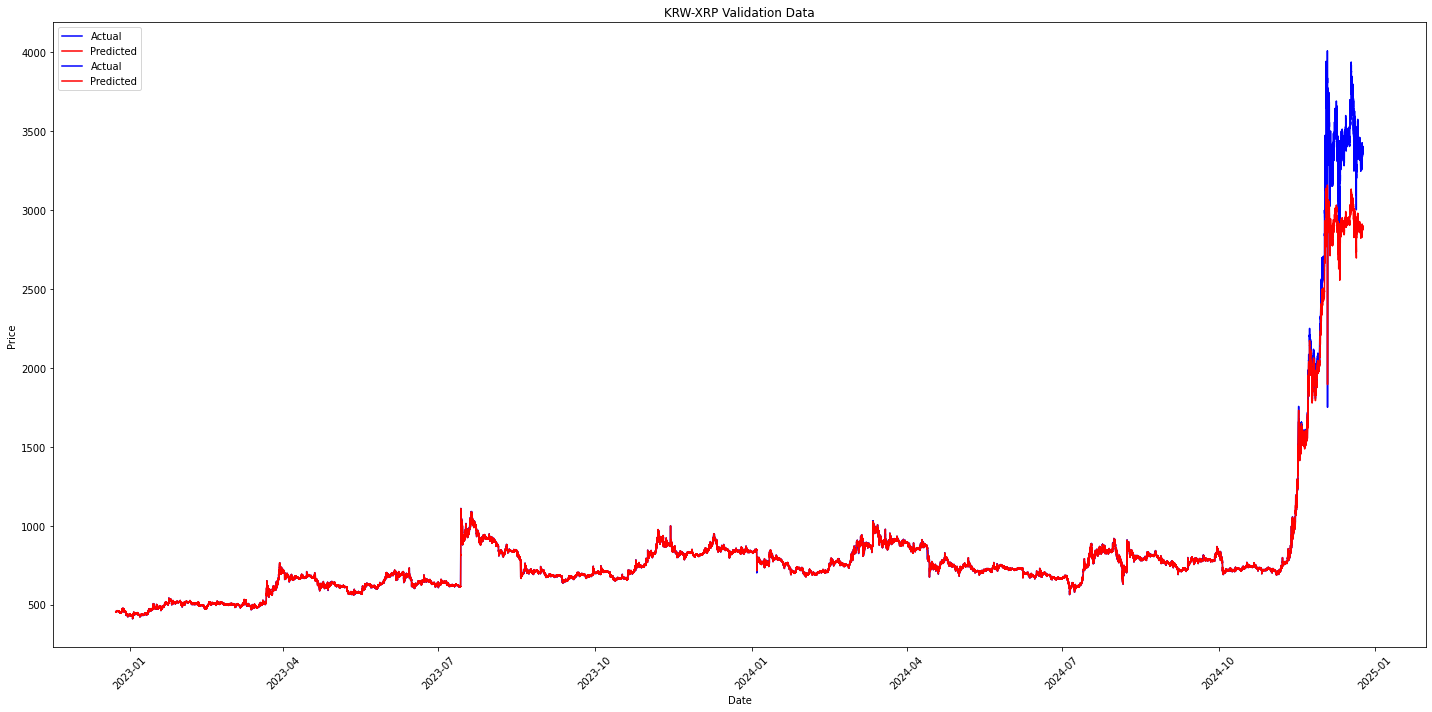

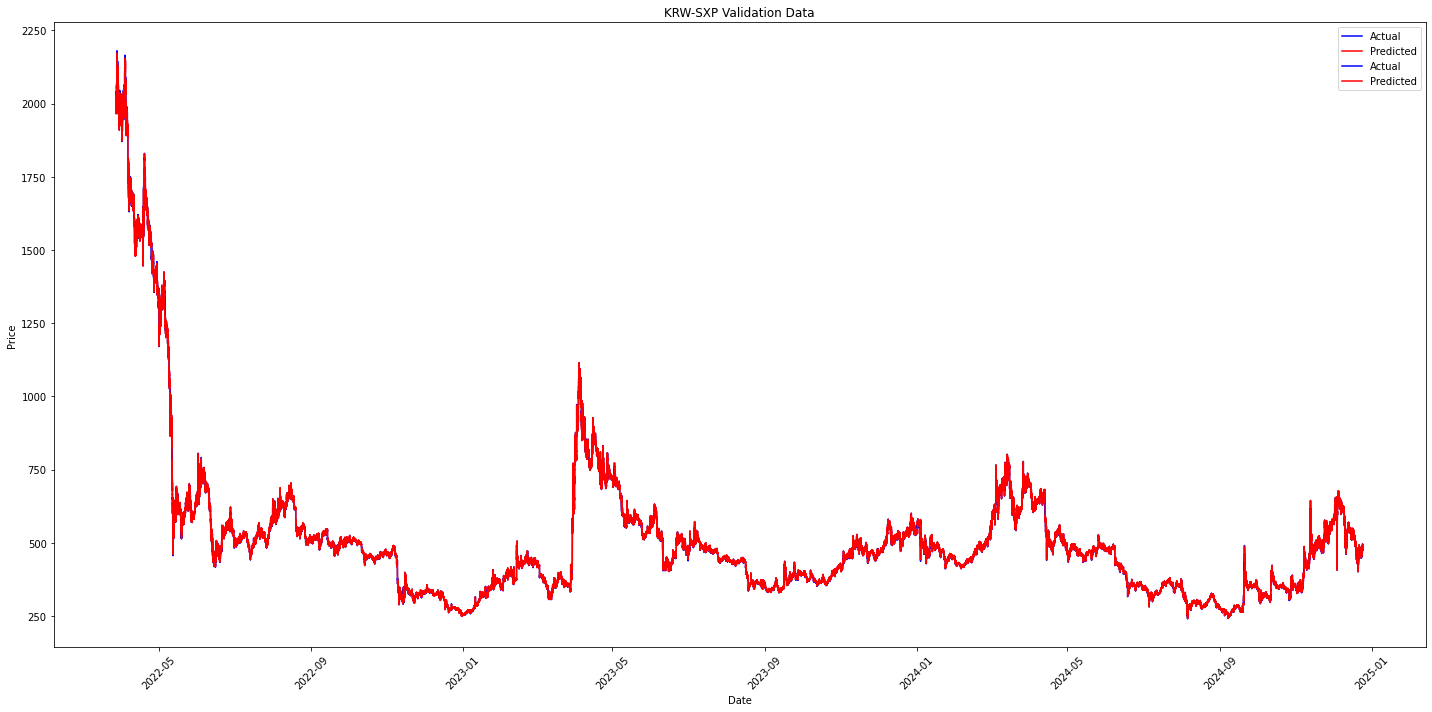

In [9]:
for ticker in coins:
    df = pd.read_csv(f'../../data/from_pyupbit/{ticker}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['close_change'] = df['close'].diff().fillna(0)
    
    df.set_index('timestamp', inplace=True)
    
    df['percentage_change'] = get_percentage(df['close'], df['close'].shift(1)).fillna(0)
    df['volatility'] = df['percentage_change'].rolling(window=5).std()
    df['avg_change_rate'] = df['percentage_change'].rolling(window=5).mean()
    
    df = df[col_list].fillna(0)
    
    print(f'{ticker} data loaded')
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, f'models/fewer/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep):
        X.append(scaled_data[i:(i + timestep), :])
        y.append(scaled_data[i + timestep, -1])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(df) * .8)
    X_train, X_val = X[:train_size], X[train_size:] # n_samples, timestep, n_features
    y_train, y_val = y[:train_size], y[train_size:]
    
    train_dates = df.index[:train_size]
    val_dates = df.index[train_size:]
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    model.save(f'models/fewer/lstm_{ticker}.h5')
    
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    
    train_predict_original = inverse_transform_predictions(train_predict, scaler)
    val_predict_original = inverse_transform_predictions(val_predict, scaler)
    y_train_original = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
    y_val_original = inverse_transform_predictions(y_val.reshape(-1, 1), scaler)
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    val_score = np.sqrt(mean_squared_error(y_val, val_predict))
    print(f'{ticker} Train RMSE: {train_score:.6f} Validation RMSE: {val_score:.6f}')
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(train_dates, y_train_original, label='Actual', color = 'Blue')
    plt.plot(train_dates, train_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Train Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.savefig(f'results/fewer/{ticker}_train.png')
    
    plt.subplot(1, 1, 1)
    plt.plot(val_dates[:-1], y_val_original, label='Actual', color = 'Blue')
    plt.plot(val_dates[:-1], val_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Validation Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig(f'results/fewer/{ticker}_val.png')
    
    last_1_day = scaled_data[-timestep:]
    X_test = last_1_day[-1, :].reshape(1, timestep, n_features)
    pred = model.predict(X_test)
    pred = inverse_transform_predictions(pred, scaler)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)[-1, -1]:.6f} Pred {pred[0]:.6f}')
    print('.')

In [11]:
import tensorflow as tf

In [12]:
for ticker in coins:
    df = pd.read_csv(f'../../data/from_pyupbit/{ticker}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['close_change'] = df['close'].diff().fillna(0)
    
    df.set_index('timestamp', inplace=True)
    
    df['percentage_change'] = get_percentage(df['close'], df['close'].shift(1)).fillna(0)
    df['volatility'] = df['percentage_change'].rolling(window=5).std()
    df['avg_change_rate'] = df['percentage_change'].rolling(window=5).mean()
    
    df = df[col_list].fillna(0)
    
    print(f'{ticker} data loaded')
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, f'models/fewer/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep):
        X.append(scaled_data[i:(i + timestep), :])
        y.append(scaled_data[i + timestep, -1])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(df) * .8)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    val_dates = df.index[train_size:]
    
    model = tf.keras.models.load_model(f'models/fewer/lstm_{ticker}.h5')
    
    early_stop = EarlyStopping(monitor='loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_val, y_val, batch_size=32, epochs=20, callbacks=[early_stop], verbose=0)
    model.save(f'models/fewer/lstm_{ticker}.h5')
    
    last_1_day = scaled_data[-timestep:]
    X_test = last_1_day[-1, :].reshape(1, timestep, n_features)
    pred = model.predict(X_test)
    pred = inverse_transform_predictions(pred, scaler)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)[-1, -1]:.6f} Pred {pred[0]:.6f}')
    print('.')

KRW-BTC data loaded
KRW-BTC train start
1/1 [==============================] - 0s 454ms/step
KRW-BTC Actual 141961000.000000 Pred 142059673.425555
.
KRW-ETH data loaded
KRW-ETH train start
1/1 [==============================] - 0s 453ms/step
KRW-ETH Actual 5125000.000000 Pred 5117665.116340
.
KRW-DOGE data loaded
KRW-DOGE train start
1/1 [==============================] - 0s 451ms/step
KRW-DOGE Actual 483.200000 Pred 483.863131
.
KRW-BIGTIME data loaded
KRW-BIGTIME train start
1/1 [==============================] - 0s 454ms/step
KRW-BIGTIME Actual 225.900000 Pred 228.282744
.
KRW-SUI data loaded
KRW-SUI train start
1/1 [==============================] - 0s 453ms/step
KRW-SUI Actual 6794.000000 Pred 6774.577679
.
KRW-UXLINK data loaded
KRW-UXLINK train start
1/1 [==============================] - 0s 460ms/step
KRW-UXLINK Actual 2581.000000 Pred 2576.419287
.
KRW-SOL data loaded
KRW-SOL train start
1/1 [==============================] - 0s 456ms/step
KRW-SOL Actual 290550.000000 Pred 290